<a href="https://colab.research.google.com/github/dcneese/imdb-analysis/blob/main/IMDb_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A Common Viewer
####Exploring Audience Tastes in Film Through IMDb Ratings & Reviews
---



# Collaborators:
* Ayush Majumdar
* David Neese

# Project Overview

---

Why do people like the movies they do? 

In light of the recent release of the 2022 Sight and Sound poll—which polls critics on their top 100 films—we thought we'd turn our attention to the ordinary movie-goer instead, and explore the question of which films are popular, why, with whom, and over which periods of time.

We shall be using the BigQuery IMDb dataset to answer our questions. The dataset tracks (among other things) the reviews left by online users on particular films, along with a rating on a 10-point scale. To answer our main question, we shall be amalgamating reviews and ratings to answer three interrelated subquestions:

1.   How are ratings and reviews broadly distributed across IMDb titles?
2.   How have these ratings and reviews changed over time?
3.   How do the ratings of the IMDb audience compare to the critics' Sight and Sound poll, and has the 2022 update brought it closer to public opinion?

Finally, we shall use an ML algorithm to try to predict the average user rating of a film based on the features we identify. 

---


# IMDb Dataset Summary

We will be using 4 tables from the dataset, totalling around 2.7GB:
- `reviews` (132.2MB): user movie reviews
- `title_akas` (1.66GB): alternate movie titles and the regions they correspond to
- `title_basics` (852.62MB): movie/tv-series name, genres, and year
- `title_ratings` (32.44MB): movie/tv-series average rating, number of ratings

### Reviews

The `review` table contains three main columns (of use to us):
- `review` (string): the text of an IMDb movie review
- `movie_id` (string): a unique id of the movie being reviewed (usually 'tt' followed by a 7/8 number code)
- `reviewer_rating` (string): the star rating (between 1 and 10) the reviewer gave the movie

The other columns are mainly redundant info (`title`, `movie_url`) or added for ML exercises (`split` and `label`, which divide the dataset for training/testing and different kinds of machine learning).

We will use `movie_id` as a foreign key for the table, as it is a uniquely specified movie index that exists in all the other tables. Given the lack of a review id and the specificity of review text, the pair (`review`, `movie_id`) is probably the closest we can get to a primary key, but fortunately, we won't need to uniquely specify reviews - we merely care about analyzing them in aggregate.
Three other things to note:
1. These reviews are given for movies only, not tv shows
2. A surprising omission from this table is a user id and review date. This unfortunately prevents us from analyzing many trends in reviewer behavior.
3. Given how this dataset was constructed, some reviewer ratings are null - if we want to find any correlations between review text and reviewer rating, we must exclude these reviews.

### Title_akas

The `title_akas` table contains information about movie titles translated into other languages, including what regions those titles were listed in. This will mostly be useful to us as an index of foreign films and where they were made.

The table contains four main columns (of use to us):
- `title_id` (string): unique title id (as above), where title is any movie, tv-series, short film, or other media form listed on IMDb
- `title` (string): the regional title of the movie
- `region` (string): the region for this title
- `language` (string): the title language
- `is_original` (boolean): flag for the original title (1 if the regional title is the original, 0 otherwise)

The other columns offer additional miscellaneous information about the regionalized title (`attributes`, `types`) and help uniquely specify the tuples (`ordering`).

As above, `title_id` serves as our foreign key, equivalent to `movie_id` and `tconst` (in the tables below). The pair of columns (`title_id`, `ordering`) serve as a primary key, but once again we will not need it.

As an additional note, the `region` column is a country's two-letter code by the [ISO 3166-1 alpha-2](https://en.wikipedia.org/wiki/ISO_3166-1_alpha-2) standard.

### Title_basics

The `title_basics` table contains information on each title in IMDb. We will mostly use six of its columns:
- `tconst` (string): unique title id (as above)
- `title_type` (string): the title's 'type', i.e. whether it is a movie, tv-series, short film &c
- `primary_title` (string): the name by which the title is most well known (may not be the original title)
- `start_year` (integer): if the title is a film, the year it released; if it is a tv-series, the year it started
- `runtime_minutes` (integer): the runtime of the title, in minutes
- `genres` (string): up to three genres associated with the title

Other columns of interest include `end_year`, the end year of a tv-series, and `original_title`, which is the film's original title.

We again use `tconst` as our foreign key, which in this case is also the table's primary key.

A few things to note about the genres column:
1. It is a string (full of csv's), not an array (important to know for parsing)
2. It contains only 3 genres a title is tagged with, of possibly many more (so we must take it as a slightly unreliable column to use)

### Title_ratings

The `title_ratings` table is the smallest of the four, containing only three columns summarizing rating information:
- `tconst` (string): unique title id (as above)
- `average_rating` (float): the average of all individual user ratings of the title (ranging from 1-10)
- `num_votes` (integer): the number of ratings the title has

We once again use `tconst` as both our foreign and primary key.

### Further Considerations

Now that we have analyzed all four tables, we make an observation about the size, in tuples, of some of our tables:
- `reviews`: 100,000 reviews
- `title_basics`: 9.4 million titles
- `title_ratings`: 1.2 million tuples

The `reviews` table is of course a subset of the many reviews on IMDb - unfortunately, we aren't given much information on the construction of this table, and it's unlikely that it was formed by a random sample. A quick count reveals 25,000 positive reviews, 25,000 negative ones, and 50,000 unmarked ones, which suggests this table is probably designed with the primary purpose of training a sentiment classifier, not reflecting the reviews on IMDb at large. This does limit what we can honestly use the table for, but we can still use it for rudementary sentiment analysis (comparing text and rating) and hope the conclusions we draw hold for most other IMDb reviews.

Further, there are around 9 times as many titles listed in `title_basics` as are given ratings in `title_ratings`, so we must either conclude that most titles on IMDb receive no ratings at all, or that our ratings dataset is incomplete. Again, for the sake of the generalizability of this analysis, we shall assume the former is more to blame.

# Data Exploration

## Dependencies and Setup

Authenticate and import graphics packages

In [ ]:
# Authenticate to BigQuery.
from google.colab import auth
auth.authenticate_user()
project_id = "regal-muse-368900"

In [ ]:
# Initialize BiqQuery client
from google.cloud import bigquery
client = bigquery.Client(project=project_id)

In [ ]:
# Installs
!pip install pycountry-convert  # We'll be needing this for the map in part 3.

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 10.1 MB 7.7 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 214 kB 73.2 MB/s 
     |████████████████████████████████| 316 kB 65.9 MB/s 
     |████████████████████████████████| 298 kB 54.4 MB/s 
     |████████████████████████████████| 297 kB 73.4 MB/s 
     |████████████████████████████████| 297 kB 71.0 MB/s 
     |████████████████████████████████| 297 kB 76.3 MB/s 
     |████████████████████████████████| 296 kB 48.7 MB/s 
     |████████████████████████████████| 296 kB 48.3 MB/s 
     |████████████████████████████████| 280 kB 67.8 MB/s 
     |████████████████████████████████| 280 kB 53.9 MB/s 
     |████████████████████████████████| 280 kB 75.1 MB/s 
     |████████████████████████████████| 280 kB 80.0 MB/s 
     |███████████████

In [ ]:
# Imports
import math
import matplotlib as mplt
import matplotlib.pyplot as ply
import numpy as np 
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import pycountry_convert as coco
import random

%matplotlib inline

## 1 Preliminary Investigations: Ratings & Reviews

Here we attempt to answer some general questions about movie ratings, just to get a feel for the broader features of the data. This section is mostly composed of top 10 lists (a time-honored metric for cinephiles) measured along different axes. Deeper analysis follows in part two (changes over time) below.

We'll start with a distribution of ratings on the platform, across all titles - this gives us an idea of how charitable movie watchers/raters, at least on IMDb, tend to be:

In [ ]:
%%bigquery s1a --project $project_id

SELECT
  COUNT(tconst),
  CASE
    WHEN average_rating BETWEEN 0 AND 1 THEN 1
    WHEN average_rating BETWEEN 1 AND 2 THEN 2
    WHEN average_rating BETWEEN 2 AND 3 THEN 3
    WHEN average_rating BETWEEN 3 AND 4 THEN 4
    WHEN average_rating BETWEEN 4 AND 5 THEN 5
    WHEN average_rating BETWEEN 5 AND 6 THEN 6
    WHEN average_rating BETWEEN 6 AND 7 THEN 7
    WHEN average_rating BETWEEN 7 AND 8 THEN 8
    WHEN average_rating BETWEEN 8 AND 9 THEN 9
    WHEN average_rating BETWEEN 9 AND 10 THEN 10
  END AS rating,
FROM `bigquery-public-data.imdb.title_ratings`
GROUP BY rating
ORDER BY rating ASC

In [ ]:
%%bigquery s1a2 --project $project_id

SELECT
  AVG(average_rating) AS average_rating,
  STDDEV(average_rating) AS stddev_rating
FROM `bigquery-public-data.imdb.title_ratings`

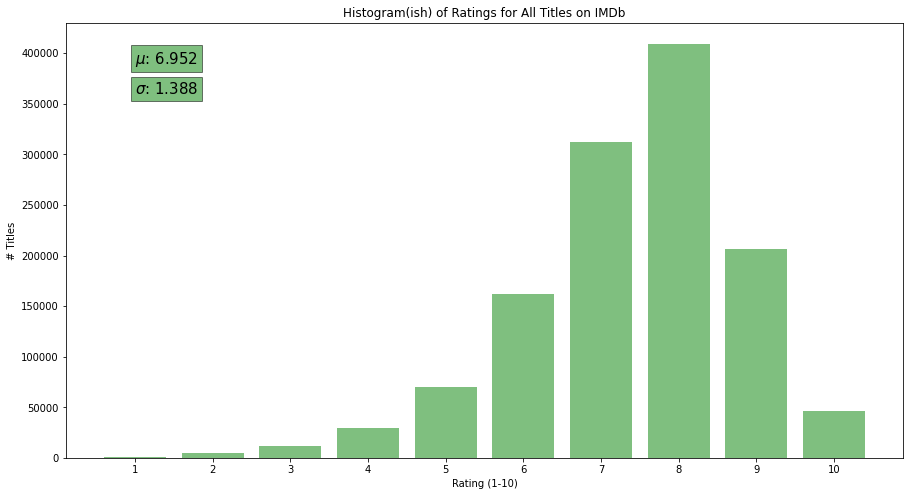

In [ ]:
mplt.pyplot.figure(figsize=(15,8))
mplt.pyplot.bar(s1a['rating'], s1a['f0_'], color='green', alpha = 0.5)
mplt.pyplot.title("Histogram(ish) of Ratings for All Titles on IMDb") #change the font size of the title
mplt.pyplot.xlabel("Rating (1-10)")
mplt.pyplot.ylabel("# Titles")
mplt.pyplot.text(1, 390000, f"$\mu$: {round(s1a2['average_rating'][0], 3)}", fontsize = 15, bbox = dict(facecolor = 'green', alpha = 0.5))
mplt.pyplot.text(1, 360000, f"$\sigma$: {round(s1a2['stddev_rating'][0], 3)}", fontsize = 15, bbox = dict(facecolor = 'green', alpha = 0.5))
mplt.pyplot.locator_params(axis='x', nbins=11)
mplt.pyplot.show()

So reviewers are much more likely to leave positive reviews than negative ones (the distribution has a mean around 7, with left skew), with even the positive extremes (9-10) being much more common than the negative extremes (0-2) by a factor of around 10:1. Keeping in mind that each bucket n represents ratings between n-1 and n, most movies were given an average rating of 7 or above, which reflects either a generous and mostly satisfied audience or a healthy global film industry. People are by and large getting what they want from entertainment media.

Next we print out some pretty standard top ten lists, for movies and tv series. First, we rank them by rating, adding a qualification that they must have at least received 50,000 votes (or 25,000 in the case of tv-series). This prevents titles with a small number of overwhelmingly positive views from making the list, while ensuring that highly rated titles that aren't overwhelmingly popular (compare our threshold of 50,000 to the 2,600,000 ratings on The Dark Knight) do.

In [ ]:
%%bigquery s1b1 --project $project_id

SELECT
  primary_title,
  average_rating
FROM `bigquery-public-data.imdb.title_ratings` ratings
JOIN `bigquery-public-data.imdb.title_basics` titles
  ON ratings.tconst = titles.tconst
WHERE title_type = 'movie' AND num_votes > 50000
ORDER BY average_rating DESC
LIMIT 10

In [ ]:
s1b1

,primary_title,average_rating
0,The Shawshank Redemption,9.3
1,The Godfather,9.2
2,12 Angry Men,9.0
3,Schindler's List,9.0
4,The Dark Knight,9.0
5,The Godfather Part II,9.0
6,The Lord of the Rings: The Return of the King,9.0
7,Jai Bhim,8.9
8,Pulp Fiction,8.9
9,Inception,8.8


And for television series—

In [ ]:
%%bigquery s1b2 --project $project_id

SELECT
  primary_title,
  average_rating
FROM `bigquery-public-data.imdb.title_ratings` ratings
JOIN `bigquery-public-data.imdb.title_basics` titles
  ON ratings.tconst = titles.tconst
WHERE title_type = 'tvSeries' AND num_votes > 25000
ORDER BY average_rating DESC
LIMIT 10

In [ ]:
s1b2

,primary_title,average_rating
0,Breaking Bad,9.5
1,The Heroes,9.4
2,Scam 1992: The Harshad Mehta Story,9.3
3,The Wire,9.3
4,Avatar: The Last Airbender,9.3
5,The Chosen,9.3
6,The World at War,9.2
7,The Filthy Frank Show,9.2
8,Game of Thrones,9.2
9,Aspirants,9.2


By popularity, we have:

In [ ]:
%%bigquery s1c1 --project $project_id

SELECT
  primary_title,
  num_votes
FROM `bigquery-public-data.imdb.title_ratings` ratings
JOIN `bigquery-public-data.imdb.title_basics` titles
  ON ratings.tconst = titles.tconst
WHERE title_type = 'movie'
ORDER BY num_votes DESC
LIMIT 10

In [ ]:
s1c1

,primary_title,num_votes
0,The Shawshank Redemption,2666384
1,The Dark Knight,2639307
2,Inception,2338964
3,Fight Club,2111815
4,Forrest Gump,2066842
5,Pulp Fiction,2041014
6,The Matrix,1905005
7,The Lord of the Rings: The Fellowship of the Ring,1867230
8,The Godfather,1847715
9,The Lord of the Rings: The Return of the King,1838077


And for television series—

In [ ]:
%%bigquery s1c2 --project $project_id

SELECT
  primary_title,
  num_votes
FROM `bigquery-public-data.imdb.title_ratings` ratings
JOIN `bigquery-public-data.imdb.title_basics` titles
  ON ratings.tconst = titles.tconst
WHERE title_type = 'tvSeries'
ORDER BY num_votes DESC
LIMIT 10

In [ ]:
s1c2

,primary_title,num_votes
0,Game of Thrones,2087894
1,Breaking Bad,1869789
2,Stranger Things,1177575
3,Friends,991643
4,The Walking Dead,987396
5,Sherlock,923464
6,The Big Bang Theory,806480
7,Dexter,725043
8,How I Met Your Mother,682607
9,The Office,594257


Now we can find popular titles that are more highly rated than they should be, or less popular ones that are not as highly viewed as they should be.

Our initial thought was to rank the films by a metric dividing rating count by average rating, but the simpler solution of ranking each film by popularity and average rating, then finding the difference, ended up making more sense. The first approach had limited success because of how overwhelmingly popular the most popular films on IMDb are - the `numvotes` metric is far more skewed than the `average_rating` metric.

For both lists, underrated and overrated movies, we faced some discretionary decisions that had no obvious solutions. For underrated films, we wanted to strike a balance between finding reasonably out of the way films and finding ones with more than just a small cult following. Likewise, for overrated films we wanted to find very popular films that weren't very good, not just very good films that had become suitably popular in time. 

For the underrated films, we decided on a `num_votes` threshold of 100,000 ratings - this seemed like a reasonable compromise between getting fairly unknown films that weren't entirely obscure. For overrated films, we decided to select films with ratings below 8, just so overwhelmingly popular but still very good movies wouldn't all be considered overrated.

Here are our top ten most underrated and most overrated movies:

In [ ]:
# Underrated Titles - more underrated version
%%bigquery s1e1 --project $project_id

SELECT
  primary_title,
  DENSE_RANK() OVER(ORDER BY average_rating DESC) AS quality,
  DENSE_RANK() OVER(ORDER BY num_votes DESC) AS popularity,
  DENSE_RANK() OVER(ORDER BY average_rating DESC) - DENSE_RANK() OVER(ORDER BY num_votes DESC) AS difference
FROM `bigquery-public-data.imdb.title_ratings` ratings
JOIN `bigquery-public-data.imdb.title_basics` titles
  ON ratings.tconst = titles.tconst
WHERE num_votes > 100000 -- tuned having seen lists for 50000, 500000, 1000000
ORDER BY difference ASC
LIMIT 10

In [ ]:
s1e1

,primary_title,quality,popularity,difference
0,The Americans,15,2459,-2444
1,The Cider House Rules,25,2461,-2436
2,Elizabeth,25,2458,-2433
3,Overlord,33,2464,-2431
4,Sharp Objects,18,2447,-2429
5,Philomena,23,2452,-2429
6,A Cure for Wellness,35,2463,-2428
7,Justified,13,2441,-2428
8,Self/less,34,2462,-2428
9,Running Scared,26,2453,-2427


In [ ]:
# Overrated Titles
%%bigquery s1e2 --project $project_id

SELECT
  primary_title,
  DENSE_RANK() OVER(ORDER BY average_rating DESC) AS quality,
  DENSE_RANK() OVER(ORDER BY num_votes DESC) AS popularity,
  DENSE_RANK() OVER(ORDER BY average_rating DESC) - DENSE_RANK() OVER(ORDER BY num_votes DESC) AS difference
FROM `bigquery-public-data.imdb.title_ratings` ratings
JOIN `bigquery-public-data.imdb.title_basics` titles
  ON ratings.tconst = titles.tconst
WHERE average_rating < 8
ORDER BY difference DESC
LIMIT 10

In [ ]:
s1e2

,primary_title,quality,popularity,difference
0,The Hunger Games,8,5,3
1,Thor,10,8,2
2,Iron Man 3,9,7,2
3,Avatar,2,1,1
4,Captain America: The First Avenger,11,10,1
5,Avengers: Age of Ultron,7,6,1
6,Star Wars: Episode I - The Phantom Menace,15,16,-1
7,Titanic,1,2,-1
8,Star Wars: Episode VII - The Force Awakens,2,4,-2
9,Iron Man,1,3,-2


(Just noting that Marvel and Star Wars represent over half this list . . .)

These overrated and underrated lists are, of course, nowhere near as definitive as, say, the popular list. They are two of many possible lists that could have been generated with similar philosophies. Not only does changing the threshold values (average rating less than a certain number, number of ratings above a certain number) change which titles end up on the list, but even changing the ranking mechanism does. Using `DENSE_RANK()` vs `RANK()`, for example, had a noticeable impact on our output—dense rank equalized ties and saw the more popular films shifting around more, whereas rank equalized ties but also propogated their effect to the less popular films, shooting them down or up the rankings with small changes and massively boosting their difference metric.

The point of these two lists is merely to show how popularity (how many people watch a film) and popular opinion (what they think of it) can differ, and what it can look like in our dataset. For example, check out the new top 10 underrated/overrated lists below and how much they differ from the ones above (notice especially how the difference value changes with a stricter popularity threshold, or using the `RANK()` function instead).

In [ ]:
# Underrated films v2 - now emphasizing films higher up in popularity
%%bigquery s1e3 --project $project_id

SELECT
  primary_title,
  DENSE_RANK() OVER(ORDER BY average_rating DESC) AS quality,
  DENSE_RANK() OVER(ORDER BY num_votes DESC) AS popularity,
  DENSE_RANK() OVER(ORDER BY average_rating DESC) - DENSE_RANK() OVER(ORDER BY num_votes DESC) AS difference
FROM `bigquery-public-data.imdb.title_ratings` ratings
JOIN `bigquery-public-data.imdb.title_basics` titles
  ON ratings.tconst = titles.tconst
WHERE num_votes > 1000000 -- must actually get popular films - tons of films with very few reviews (can tune this to see which films are not popular at threshold)
ORDER BY difference ASC
LIMIT 10

In [ ]:
s1e3

,primary_title,quality,popularity,difference
0,One Flew Over the Cuckoo's Nest,7,62,-55
1,Eternal Sunshine of the Spotless Mind,11,63,-52
2,Reservoir Dogs,11,61,-50
3,The Shining,10,60,-50
4,Braveheart,10,58,-48
5,Up,11,57,-46
6,The Lion King,9,54,-45
7,Deadpool,14,59,-45
8,Star Wars: Episode VI - Return of the Jedi,11,55,-44
9,Finding Nemo,12,56,-44


In [ ]:
# Overrated films v2 - now emphasizing films lower down in popularity
%%bigquery s1e4 --project $project_id

SELECT
  primary_title,
  RANK() OVER(ORDER BY average_rating DESC) AS quality,
  RANK() OVER(ORDER BY num_votes DESC) AS popularity,
  RANK() OVER(ORDER BY average_rating DESC) - RANK() OVER(ORDER BY num_votes DESC) AS difference
FROM `bigquery-public-data.imdb.title_ratings` ratings
JOIN `bigquery-public-data.imdb.title_basics` titles
  ON ratings.tconst = titles.tconst
WHERE average_rating < 9
ORDER BY difference DESC
LIMIT 10

In [ ]:
s1e4

,primary_title,quality,popularity,difference
0,Sadak 2,1193621,2517,1191104
1,Reis,1193901,3190,1190711
2,Radhe,1190264,1332,1188932
3,Cumali Ceber,1193901,5157,1188744
4,Justin Bieber: Never Say Never,1191703,3082,1188621
5,Smolensk,1193176,5094,1188082
6,Disaster Movie,1190264,2623,1187641
7,The Cost of Deception,1192178,5260,1186918
8,Manos: The Hands of Fate,1191703,5404,1186299
9,Superbabies: Baby Geniuses 2,1192178,6050,1186128


For a final top ten list, we measure the universal appeal of films by finding how many languages they've been translated into. This one throws up a few surprises (or at least we thought so):

In [ ]:
%%bigquery s1d --project $project_id

SELECT
  COUNT(DISTINCT language) AS num_diff_languages,
  titles.original_title
FROM `bigquery-public-data.imdb.title_ratings` ratings
JOIN `bigquery-public-data.imdb.title_basics` titles
  ON ratings.tconst = titles.tconst
JOIN `bigquery-public-data.imdb.title_akas` akas
  ON titles.tconst = akas.title_id
WHERE primary_title NOT LIKE 'Testing%'
GROUP BY titles.primary_title, titles.original_title
ORDER BY num_diff_languages DESC
LIMIT 10

In [ ]:
s1d

,num_diff_languages,original_title
0,32,The Lion King
1,32,A Christmas Carol
2,31,Shaun the Sheep Movie
3,26,Jaws
4,25,Home Alone
5,25,The Black Cauldron
6,24,A Wrinkle in Time
7,22,Close Encounters of the Third Kind
8,22,Snow White and the Seven Dwarfs
9,22,Edward Scissorhands


The Lion King and Snow White are quite explicable - of course Disney would market its animated films far and wide - but we, at least, were a little baffled by the popularity of Edward Scissorhands. . . .

And for a final question, we ask how audiences respond to films of varying length - this will reappear in the next section.

In [ ]:
%%bigquery s1h --project $project_id

SELECT 
  runtime_minutes,
  average_rating,
  num_votes
FROM `bigquery-public-data.imdb.title_ratings` ratings
JOIN `bigquery-public-data.imdb.title_basics` titles
  ON ratings.tconst = titles.tconst
WHERE runtime_minutes IS NOT NULL AND title_type = 'movie' AND runtime_minutes <= 600 -- consider, say, the runtime of Shoah (9 hours) as a good upper limit

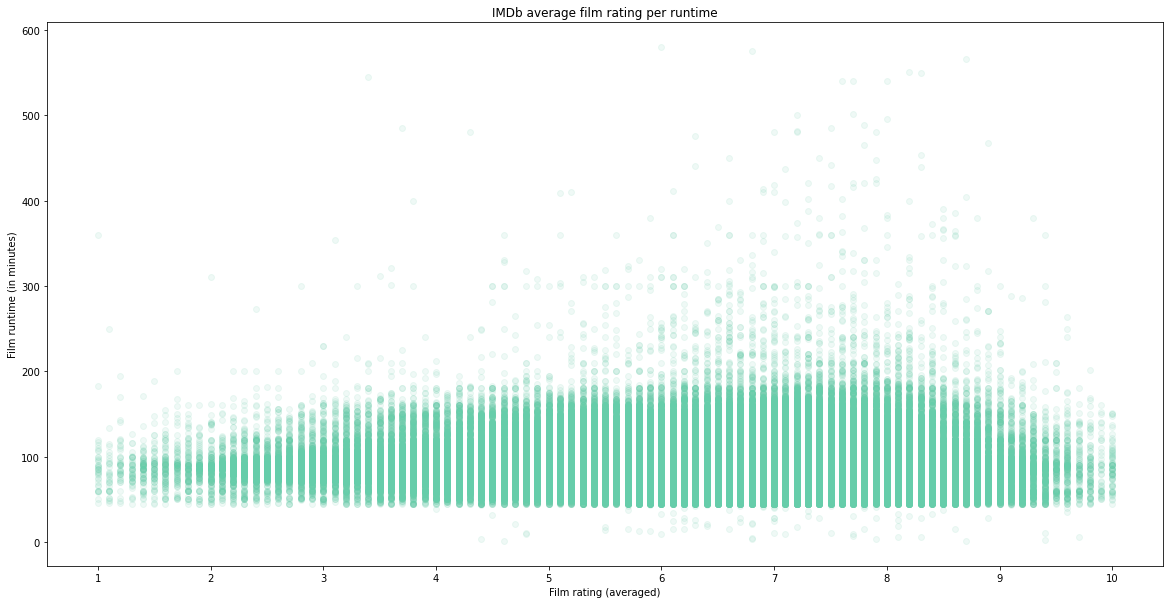

In [ ]:
mplt.pyplot.figure(figsize=(20, 10))
mplt.pyplot.scatter(s1h["average_rating"], s1h["runtime_minutes"], c="mediumaquamarine", alpha=0.1)
mplt.pyplot.title("IMDb average film rating per runtime")
mplt.pyplot.ylabel("Film runtime (in minutes)")
mplt.pyplot.xlabel("Film rating (averaged)")
mplt.pyplot.xticks(list(range(1,11)))
# mplt.pyplot.yscale("log")
mplt.pyplot.show()

The left skew and the presence of highly-rated outliers (around the 400, 500, 600 mark) would seem to imply that, surprisingly, few people are willing to condemn even the longest of films.

## 2 Changes over time

We'll now explore how people respond to films from the past, and how their responses change with the change of film styles over time.

To do this we'll mostly bucket films by decade, and track various statistics in relation to that.

We've confined our queries to a hundred-year-long window, 1920 to 2020, though the database extends twenty years further into the past. (Entries about television programmes from the 1900s struck us as either errors or lurid fictions.)

To begin with, we ask if people prefer contemporary films to classic ones by plotting the average rating of all the films in a given year.

In [ ]:
%%bigquery s2a --project $project_id
SELECT 
      CASE
        WHEN start_year >= 1920 AND start_year <= 1930 THEN "1920s"
        WHEN start_year > 1930 AND start_year <= 1940 THEN "1930s"
        WHEN start_year > 1940 AND start_year <= 1950 THEN "1940s"
        WHEN start_year > 1950 AND start_year <= 1960 THEN "1950s"
        WHEN start_year > 1960 AND start_year <= 1970 THEN "1960s"
        WHEN start_year > 1970 AND start_year <= 1980 THEN "1970s"
        WHEN start_year > 1980 AND start_year <= 1990 THEN "1980s"
        WHEN start_year > 1990 AND start_year <= 2000 THEN "1990s"
        WHEN start_year > 2000 AND start_year <= 2010 THEN "2000s"
        WHEN start_year > 2010 AND start_year <= 2020 THEN "2010s"
      END as decade,
      AVG(average_rating) as avg_rating
FROM 
  `bigquery-public-data.imdb.title_ratings` ratings, 
  `bigquery-public-data.imdb.title_basics` basics
WHERE 
  ratings.tconst = basics.tconst AND basics.title_type = "movie" AND basics.start_year BETWEEN 1920 and 2020
GROUP BY start_year
ORDER BY decade ASC

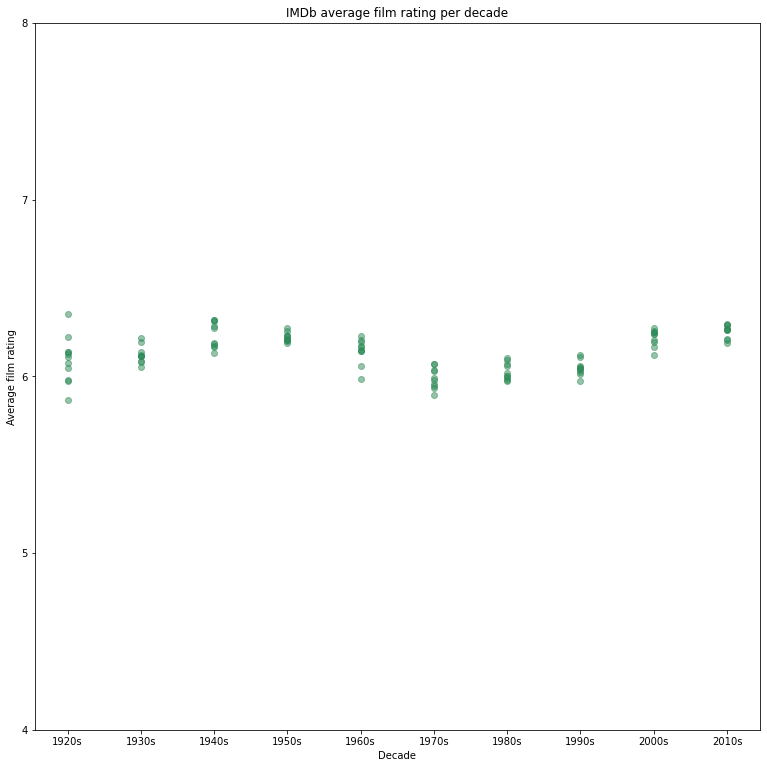

In [ ]:
ply.figure(figsize=(13, 13))
ply.scatter(s2a["decade"], s2a["avg_rating"], c="seagreen", alpha=0.5)
ply.title("IMDb average film rating per decade")
ply.xlabel("Decade")
ply.ylabel("Average film rating")
ply.yticks(range(4, 9))
ply.show()

Each blob represents a year.

The trend is vaguely sinusoidal, meaning that certain decades (the forties and fifties) are thought to be more attractive than others. But on the whole, surprisingly (to us), the year the film was made seems to matter very little. 

The data also suggests that most people reckon we're on an upswing, at least so far as the quality of their entertainment is concerned.

Perhaps this trend can be explained in part by the insular nature of many film-viewers. They may specialise in particular decades - the French New Wave, say, or German Expressionism - and consequently be ignorant of others, such as Parallel Cinema or Italian Neorealism; therefore, they rate what they like, and ignore the rest.

---

Next, we plot the average runtime of a film against the decade.

In [ ]:
%%bigquery s2bi --project $project_id
SELECT 
      CASE
        WHEN start_year >= 1920 AND start_year <= 1930 THEN "1920s"
        WHEN start_year > 1930 AND start_year <= 1940 THEN "1930s"
        WHEN start_year > 1940 AND start_year <= 1950 THEN "1940s"
        WHEN start_year > 1950 AND start_year <= 1960 THEN "1950s"
        WHEN start_year > 1960 AND start_year <= 1970 THEN "1960s"
        WHEN start_year > 1970 AND start_year <= 1980 THEN "1970s"
        WHEN start_year > 1980 AND start_year <= 1990 THEN "1980s"
        WHEN start_year > 1990 AND start_year <= 2000 THEN "1990s"
        WHEN start_year > 2000 AND start_year <= 2010 THEN "2000s"
        WHEN start_year > 2010 AND start_year <= 2020 THEN "2010s"
      END as decade,
      AVG(runtime_minutes) as avg_runtime
FROM 
  `bigquery-public-data.imdb.title_basics` basics
WHERE 
  basics.title_type = "movie" AND basics.start_year BETWEEN 1920 and 2020
GROUP BY start_year
ORDER BY decade ASC

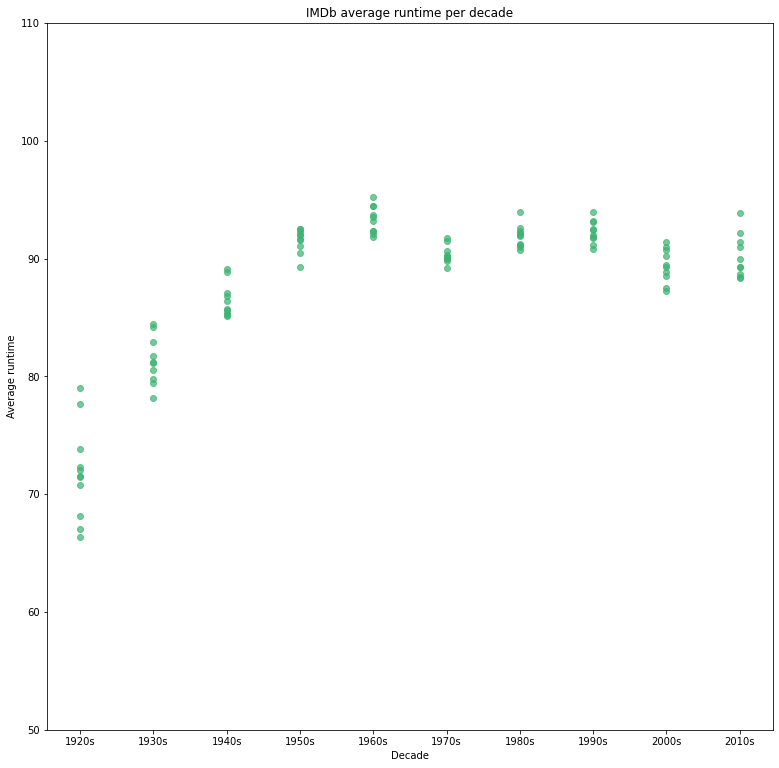

In [ ]:
ply.figure(figsize=(13, 13))
ply.scatter(s2bi["decade"], s2bi["avg_runtime"], c="mediumseagreen", alpha=0.7)
ply.title("IMDb average runtime per decade")
ply.xlabel("Decade")
ply.ylabel("Average runtime")
ply.yticks(range(50, 120, 10))
ply.show()

In general the curve grows rapidly and then shallows out, suggesting that the heyday of the long film was in the 60s - 95 minutes on average, or an hour and a half. Perhaps this has something to do with the rise of forms like the epic film (say, Ben Hur) and the science fiction film (2001: A Space Odyssey), and the availability of more sophisticated special effects.

(Interestingly, per the previous chart, when it comes to the popular perception of the quality of these films, the 60s have the lowest average rating overall.)

---


Now for television series:

In [ ]:
%%bigquery s2bii --project $project_id

SELECT 
  DISTINCT basics.tconst, 
  basics.original_title AS name, 
  end_year - start_year AS num_years_run,
  average_rating
FROM 
  `bigquery-public-data.imdb.title_basics` basics,
  `bigquery-public-data.imdb.title_ratings` ratings
WHERE 
  title_type = "tvSeries" AND start_year IS NOT NULL AND end_year IS NOT NULL
  AND start_year BETWEEN 1920 and 2020
  AND ratings.tconst = basics.tconst
GROUP BY tconst, basics.original_title, end_year, start_year, average_rating
ORDER BY num_years_run DESC

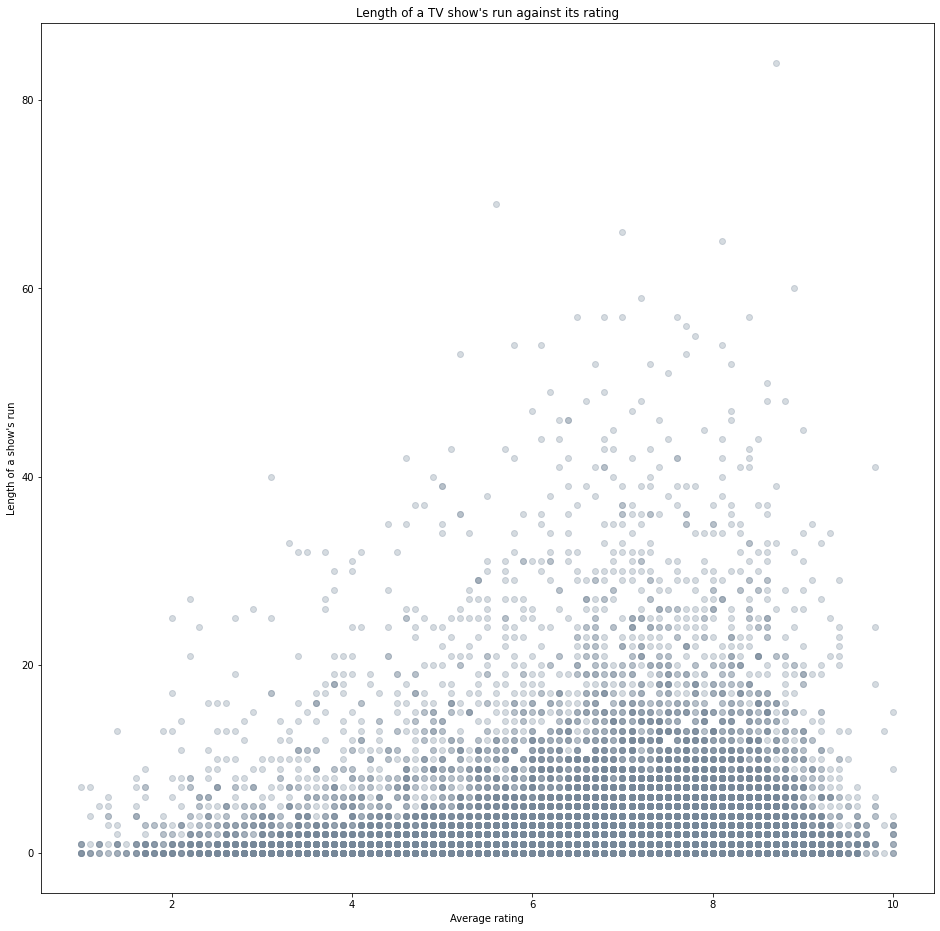

In [ ]:
ply.figure(figsize=(16, 16))
ply.scatter(s2bii["average_rating"], s2bii["num_years_run"], c="lightslategrey", alpha = 0.3)
ply.title("Length of a TV show's run against its rating")
ply.xlabel("Average rating")
ply.ylabel("Length of a show's run")
ply.show()

We plotted the number of years a show has run against the average rating. 

The shows in the database can have fantastically long lifespans--up to 80 years, apparently, in some cases. These are probably news channels or chat shows.

Again the graph has a left skew, which would maybe suggest that people don't mind television series going on too long. One explanation for this might be that we chose to plot the ratings for the overall show, rather than its seasons or its episodes; when called upon to rate a show as a whole perhaps a viewer typically judges it by its best than by its worst. 

Interestingly this is despite the fact that most viewers feel that a TV series declines as it goes on (see below).

---

Next, we plot the rise and fall in popularity of the different genres of film:

In [ ]:
%%bigquery s2c --project $project_id
WITH genreArray AS (
  SELECT 
    start_year, SPLIT(genres) as genre
  FROM
    `bigquery-public-data.imdb.title_basics`
  WHERE
    title_type = "movie"
)

SELECT 
      CASE
        WHEN start_year >= 1920 AND start_year <= 1930 THEN "1920s"
        WHEN start_year > 1930 AND start_year <= 1940 THEN "1930s"
        WHEN start_year > 1940 AND start_year <= 1950 THEN "1940s"
        WHEN start_year > 1950 AND start_year <= 1960 THEN "1950s"
        WHEN start_year > 1960 AND start_year <= 1970 THEN "1960s"
        WHEN start_year > 1970 AND start_year <= 1980 THEN "1970s"
        WHEN start_year > 1980 AND start_year <= 1990 THEN "1980s"
        WHEN start_year > 1990 AND start_year <= 2000 THEN "1990s"
        WHEN start_year > 2000 AND start_year <= 2010 THEN "2000s"
        WHEN start_year > 2010 AND start_year <= 2020 THEN "2010s"
      END as decade,
      flattenedGenre as genre,
      COUNT(genre) AS genre_counts
FROM 
  genreArray, UNNEST(genreArray.genre) as flattenedGenre
WHERE
  start_year BETWEEN 1920 and 2020
GROUP BY decade, genre
ORDER BY decade ASC, genre_counts DESC

In [ ]:
df = pd.DataFrame(s2c)
df = df.astype({
    column: np.int64
    for column in df.drop(["decade", "genre"], axis=1).columns
})
fig = px.line(df, x="decade", y="genre_counts", color="genre", title="Movies per genre, per decade",
              labels = {
                  "decade": "Decade",
                  "genre_counts": "Number of movies"
              }
              )
fig.update_layout(
    title_font_family="Helvetica",
    font_family="Helvetica",
    updatemenus=[
        dict(
            type = "buttons",
            direction = "right",
            buttons=list([
                dict(
                    args=[{"yaxis.type": "linear"}],
                    label="LINEAR",
                    method="relayout"
                ),
                dict(
                    args=[{"yaxis.type": "log"}],
                    label="LOG",
                    method="relayout"
                )
            ]),
        ),
    ]
)
fig.show()


By far the most popular genres are drama and documentary films, with comedy a distant third. Both drama and documentary films seem to have grown exponentially in popularity since the 1990s.

Of course, nearly all the genres show a sharp increase from around 2000 on, no doubt indicating the proliferation of the internet, streaming services, and other avenues through which films and tv shows can be consumed. 

Some genres seem to be irrevocably dated--for example (predictably) the western. Other genres seem to undergo a periodic rise and fall--musicals, for instance, seem to have been plentiful in the 40s and 50s, but rare in the 80s and the 90s; and in the 2010s they seem to be making a resurgence.

We may note that the popularity of certain genres may not necessarily reflect on their appeal to the public. Fantasy and sci-fi, for instance, the genre of some of the most popular films and shows (see above and below) lag behind many other genres. This is probably because fantasy and science-fiction are more expensive to produce, not because the public likes them less. 

---

We turn to a more granular appraisal of the reception of tv shows. First, we plot the average rating of a tv show over its seasons:

In [ ]:
%%bigquery s2di --project $project_id
SELECT 
  (SELECT 
    original_title 
  FROM `bigquery-public-data.imdb.title_basics` 
    basics 
  WHERE 
    episodes.parent_tconst = basics.tconst
  ) as show,
  season_number,
  AVG(average_rating) as average_rating
FROM
  `bigquery-public-data.imdb.title_episode` episodes,
  `bigquery-public-data.imdb.title_ratings` ratings
WHERE
  episodes.tconst = ratings.tconst
  and season_number IS NOT NULL
  and season_number BETWEEN 1 AND 20 --picking a reasonable number of seasons . . .
  and average_rating IS NOT NULL
GROUP BY show, season_number
ORDER BY show

In [ ]:
ply.figure(figsize=(15, 15))
ply.scatter(s2di["season_number"], s2di["average_rating"], c="seagreen", alpha = 0.5)
ply.title("Average rating of a show over seasons")
ply.xlabel("Season")
ply.ylabel("Average rating")
ply.xticks(list(range(1, 21)))
ply.show()

NameError: ignored

Expectedly, the sharpest differences of opinion arise over the first season. Then both positive and negative opinion of the show fall off, and by the twentieth season the spread is thin. This suggests a gradual decay in the quality of a television programme over the course of its many seasons. Notably, while there are a few outliers (10s) well up to season 14 of some shows, from season 15 onwards truly excellent ratings (9s and 10s) become very rare.

---

Instead of focusing on every single show in our database, we turn our attention to the top ten most popular shows (as judged by the ```num_votes``` variable), and plot the average rating over all seasons:


In [ ]:
%%bigquery s2dii --project $project_id
WITH genreArray AS (
  SELECT 
    original_title, SPLIT(genres) as genre
  FROM
    `bigquery-public-data.imdb.title_basics`
  WHERE
    title_type = "tvSeries"
), dramas AS(
  SELECT 
    DISTINCT basics.tconst, 
    basics.original_title AS name, 
    flattenedGenre AS genre
  FROM 
    `bigquery-public-data.imdb.title_basics` basics,
    genreArray,
    UNNEST(genreArray.genre) as flattenedGenre
  WHERE 
    title_type = "tvSeries" AND start_year IS NOT NULL AND end_year is not NULL
    AND start_year BETWEEN 2000 and 2020
    AND flattenedGenre = "Drama"
  GROUP BY tconst, basics.original_title, end_year, start_year, flattenedGenre
), topTenDramas AS (
  SELECT dramas.tconst as tconst, dramas.name as original_title, num_votes
  FROM 
    dramas,`bigquery-public-data.imdb.title_ratings` ratings
  WHERE
    dramas.tconst = ratings.tconst
  ORDER BY num_votes DESC
  LIMIT 10
)

SELECT 
  shows.original_title as show,
  show_tconst as show_tconst,
  season_number,
  AVG(ratings.average_rating) as average_rating
FROM
  (SELECT 
    original_title,
    topTenDramas.tconst as show_tconst,
    episodes.tconst as episode_tconst,
    season_number,
    episode_number
  FROM 
    topTenDramas,
    `bigquery-public-data.imdb.title_episode` episodes 
  WHERE 
    episodes.parent_tconst = topTenDramas.tconst
  ) as shows,
  `bigquery-public-data.imdb.title_ratings` ratings
WHERE
  episode_tconst = ratings.tconst
GROUP BY show, show_tconst, season_number
ORDER BY show, season_number

In [ ]:
df = pd.DataFrame(s2dii)
df = df.astype({
    column: np.float64
    for column in df.drop(["show", "show_tconst", "season_number"], axis=1).columns
})
fig = px.line(df, x="season_number", y="average_rating", color="show", title="Average ratings of seasons of top 10 tv shows",
              labels = {
                  "season_number": "Season",
                  "average_rating": "Average rating"
              }
              )
fig.update_xaxes(tickvals=list(range(1, 13)), ticks="inside")
fig.update_yaxes(ticks="inside")
fig.show()

Again the decline is nearly universal (with only *Breaking Bad* supplying us an exception). In some cases (*Game of Thrones*, *Sherlock*) the decline is very steep, indicating perhaps a precipitious drop in quality (as thought of by viewers). In most other cases the decline is gentle but steady, until the final season is nearly a half-point lower than the first.

## 3 Audiences and critics

Having discussed the preferences of the "common viewer," represented by the reviewers of IMDb, we now turn to the opinions of film critics, and see how they compare.

As a barometer of critical opinion we will be relying on the [Sight and Sound poll](https://en.wikipedia.org/wiki/Sight_%26_Sound), put out once a decade by the British film magazine *Sight and Sound*, which asks a group of critics and directors what they consider to be the best 100 films ever made. The latest one came out only this year.

For our purposes, we'll be relying on the last two polls, for 2022 and 2012. We will compare how many matches there are between the critics' list and the IMDb audience's top 100, and see if critical consensus and popular consensus have been drifting apart or coming closer.


We created our own database for Sight and Sound from a very simple csv. The tables have only the name of the film, and the year the film was made.

***Sight and Sound* poll, 2022**

Here is a sample of the *kinds* of films from the last 50 years that the critics chose:



In [ ]:
%%bigquery s3a0 --project $project_id
SELECT *
FROM `regal-muse-368900.sightandsound.2022`topCritics
WHERE year BETWEEN 1970 and 2020
ORDER BY year DESC
LIMIT 20

In [ ]:
s3a0

,film_name,year
0,Parasite,2019
1,Portrait of a Lady on Fire,2019
2,Get Out,2017
3,Moonlight,2016
4,Tropical Malady,2004
5,Spirited Away,2001
6,Mulholland Drive,2001
7,The Gleaners and I,2000
8,Yi Yi,2000
9,In the Mood for Love,2000


We can see that many of these are foreign or art films.

---

Now we compare with the IMDb audience's top 100, and count the number of matches between them. Of course we can't simply use the raw ratings, because then we would weight unduly highly obscure films rated excellently by only a few people. Instead, we chose 50000 votes for a film to be an adequate proxy for "popularity," i.e. a sufficient guarantee that the rating stands, however approximately, for the quality of the film.

In [ ]:
%%bigquery s3ai --project $project_id

WITH topAudiences AS(
  SELECT original_title
  FROM 
    `bigquery-public-data.imdb.title_ratings` ratings,
    `bigquery-public-data.imdb.title_basics` basics
  WHERE 
    ratings.tconst = basics.tconst
    AND num_votes >= 50000
    AND title_type = "movie"
  ORDER BY average_rating DESC
  LIMIT 100
)

SELECT 
  film_name AS films_in_common
FROM 
  `regal-muse-368900.sightandsound.2022`topCritics,
  topAudiences
WHERE film_name = original_title

In [ ]:
s3ai

,films_in_common
0,The Godfather
1,Goodfellas
2,Modern Times
3,Rear Window
4,Psycho
5,Casablanca
6,Apocalypse Now
7,City Lights
8,The Shining
9,The Apartment


There are very few--ten--matches, and interestingly all the films are American. On the basis of this we may hastily conclude that (a) there is a severe rupture between critical and popular opinion; and (b) that the average IMDb viewer is not very interested in films from other cultures. 

We can test both these conclusions further:

***Sight and Sound* poll, 2012**

Again, here are some of the kinds of films the critics chose:

In [ ]:
%%bigquery s3a0 --project $project_id
SELECT *
FROM `regal-muse-368900.sightandsound.2012`topCritics
WHERE year BETWEEN 1970 and 2020
ORDER BY year DESC
LIMIT 20

In [ ]:
s3a0

,film_name,year
0,Mulholland Drive,2001
1,In the Mood For Love,2000
2,A One and a Two,1999
3,Beau travail,1998
4,Sátántangó,1994
5,A Brighter Summer Day,1991
6,Close-Up,1989
7,Histoire(s) du cinéma,1988
8,Blue Velvet,1986
9,Shoah,1985


The list is only slightly different, though some might say there are fewer concessions to popular taste. (E.g. the 2022 list & *Get Out*.)

---


We again compare with the IMDb audience's top 100:

In [ ]:
%%bigquery s3aii --project $project_id

WITH topAudiences AS(
  SELECT original_title
  FROM 
    `bigquery-public-data.imdb.title_ratings` ratings,
    `bigquery-public-data.imdb.title_basics` basics
  WHERE 
    ratings.tconst = basics.tconst
    AND num_votes >= 50000
    AND title_type = "movie"
  ORDER BY average_rating DESC
  LIMIT 100
)

SELECT 
  film_name AS films_in_common
FROM 
  `regal-muse-368900.sightandsound.2012`topCritics,
  topAudiences
WHERE film_name = original_title

In [ ]:
s3aii

,films_in_common
0,Rear Window
1,Casablanca
2,Modern Times
3,Psycho
4,City Lights
5,Apocalypse Now
6,North by Northwest



There are even fewer matches, and perhaps we could tentatively venture that the 2022 poll has drawn nearer to public opinion. Whether this is a good or a bad thing will, we imagine, be debated fervently.

---

(As an aside, The Godfather is absent here not because it doesn't appear in the 2012 poll, but because the 2022 and 2012 polls adopted different policies when it came to multi-part works and trilogies. One of them decided to treat each entry separately, while the other decided to treat the entire trilogy as one work. That is why it doesn't show up in this list, though the two parts of the Godfather *are* in the audience's list.)

---

We can now answer if the average IMDb reviewer--whom we can probably safely assume to be an American--is at all interested in foreign film. To answer this we count the number of non-original films that are shown in a given region--that is, films *not* produced in a country yet screened in it.

In [ ]:
%%bigquery s3bi --project $project_id
SELECT 
  region, 
  COUNT(region) as num_films
FROM 
  `bigquery-public-data.imdb.title_akas` title_akas
WHERE 
  region IS NOT NULL
  and is_original_title = False
  and LENGTH(region) = 2 -- because the dataset has three-letter characters that signify invalid regions
  and region != "AN" -- weird instance of nation dropped from the ISO-3 standard
GROUP BY region
ORDER BY region

In [ ]:
df = pd.DataFrame(s3bi)
# run these only ONCE, the first time the query is run; otherwise the changes persist.
# df['num_films'] = df.num_films.apply(lambda x: math.log(x)) # log-scaling, otherwise the colors look hideous
#
# more weird shenanigans - plotly only accepts alpha-3 country codes, but the DB's codes are alpha-2 -
# this is all syntactic sugar to convert one to the other
#df['region'] = df.region.apply(lambda x: coco.country_name_to_country_alpha3(coco.country_alpha2_to_country_name(x)))
f = px.choropleth(df, locations=df['region'], locationmode='ISO-3', color=df['num_films'], color_continuous_scale="emrld",
                    title="Number of foreign films consumed per country (log-scaled) - mercator")
f.show()
fig = px.choropleth(df, locations=df['region'], locationmode='ISO-3', color=df['num_films'], color_continuous_scale="blugrn",
                    projection='orthographic', title="Number of foreign films consumed per country (log-scaled) - orthographic")
fig.show()

Surprisingly, the USA does rather respectably. Americans do not, it's true, watch as many foreign films as Europeans or Indians, but they are firmly in the top 10% of the world and are not as parochial as the difference betweent the Sight and Sound poll and the IMDb Top 100 might suggest.

# Data Prediction

Given all we've covered so far, one might wonder how much predictive power these insights have. The tentative answer is not much (despite what the numbers of our best predictive model tell us), which we'll explain as we go.

Our most successful attempt at an ML model is a simple logistic classifier, which uses up to 6 features (film runtime, number of ratings, number of languages translated into, and up to three genre tags) to predict whether a film's average rating is 'good' or 'bad' (i.e. above or below 5). To make sure we didn't train on woefully out of date genre trends, we restricted our training data to movies produced in or after 2000. Our three datasets range over (inclusive):
- Training: 2000-2015
- Validation: 2015-2020
- Test: 2021-2022

As for our rationale in choosing features, we decided
1. runtime didn't have too much of an effect on rating (see our last graph in part 1), but there was a slight higher chance films just shy of the two hour mark would be rated more highly.
2. number of ratings seemed very highly correlated with average rating - by and large good films are popular, and vice versa (again, part 1).
3. number of languages translated into was a more interesting out of the way stat we only later decided to include (more on that later) - we didn't measure any direct correlation between it and IMDb's 'good' movies, but just at a glance, the widely translated movies were all historically well regarded ones.
4. certain genres did seem more highly rated overall, especially when films were broken down by decade, so this seemed a no-brainer to include.

We observe the performance of our model below:

In [ ]:
# # Run this cell to create a dataset to store your model, or create in the UI

# model_dataset_name = 'imdb_titles'

# dataset = bigquery.Dataset(client.dataset(model_dataset_name))
# dataset.location = 'US'
# client.create_dataset(dataset)

Dataset(DatasetReference('regal-muse-368900', 'imdb_titles'))

In [ ]:
## CREATING AND TRAINING THE MODEL
%%bigquery --project $project_id

##### REVISED VERSION #####

CREATE OR REPLACE MODEL `imdb_titles.lang_rating_model` -- we'll call our model 'lang_rating_model'
OPTIONS(model_type='logistic_reg') AS
(
WITH languages AS(
  SELECT 
    tconst,
    num_diff_languages, 
    genres, 
    runtime_minutes
  FROM `bigquery-public-data.imdb.title_akas` akas
  JOIN `bigquery-public-data.imdb.title_basics` titles 
    ON tconst = title_id 
  JOIN (SELECT
          COUNT(DISTINCT language) AS num_diff_languages,
          titles.original_title
        FROM `bigquery-public-data.imdb.title_ratings` ratings
        JOIN `bigquery-public-data.imdb.title_basics` titles
          ON ratings.tconst = titles.tconst
        JOIN `bigquery-public-data.imdb.title_akas` akas
          ON titles.tconst = akas.title_id
        WHERE primary_title NOT LIKE 'Testing%'
        GROUP BY titles.primary_title, titles.original_title
        ORDER BY num_diff_languages DESC) numlangs
    ON numlangs.original_title = akas.title
  WHERE 
    is_original_title IS TRUE
    AND title_type = "movie"
    AND titles.start_year BETWEEN 2000 AND 2015
)


SELECT
  IF(average_rating > 5, 1, 0) AS label,
  runtime_minutes AS feature1,
  num_votes AS feature2,
  num_diff_languages AS feature3,
  SPLIT(genres)[SAFE_ORDINAL(1)] AS feature4,
  SPLIT(genres)[SAFE_ORDINAL(2)] AS feature5,
  SPLIT(genres)[SAFE_ORDINAL(3)] AS feature6
FROM languages
JOIN `bigquery-public-data.imdb.title_ratings` ratings
  ON ratings.tconst = languages.tconst
WHERE average_rating IS NOT NULL)

In [ ]:
## TRAINING INFO
%%bigquery --project $project_id

SELECT
  *
FROM
  ML.TRAINING_INFO(MODEL `imdb_titles.lang_rating_model`)

In [ ]:
## EVALUATING THE MODEL (VALIDATION SET)
%%bigquery --project $project_id

SELECT
  *
FROM
  ML.EVALUATE(MODEL `imdb_titles.lang_rating_model`, (
    WITH languages AS(
  SELECT 
    tconst,
    num_diff_languages, 
    genres, 
    runtime_minutes
  FROM `bigquery-public-data.imdb.title_akas` akas
  JOIN `bigquery-public-data.imdb.title_basics` titles 
    ON tconst = title_id 
  JOIN (SELECT
          COUNT(DISTINCT language) AS num_diff_languages,
          titles.original_title
        FROM `bigquery-public-data.imdb.title_ratings` ratings
        JOIN `bigquery-public-data.imdb.title_basics` titles
          ON ratings.tconst = titles.tconst
        JOIN `bigquery-public-data.imdb.title_akas` akas
          ON titles.tconst = akas.title_id
        WHERE primary_title NOT LIKE 'Testing%'
        GROUP BY titles.primary_title, titles.original_title
        ORDER BY num_diff_languages DESC) numlangs
    ON numlangs.original_title = akas.title
  WHERE 
    is_original_title IS TRUE
    AND title_type = "movie"
    AND titles.start_year BETWEEN 2016 AND 2020
)


SELECT
  IF(average_rating > 5, 1, 0) AS label,
  runtime_minutes AS feature1,
  num_votes AS feature2,
  num_diff_languages AS feature3,
  SPLIT(genres)[SAFE_ORDINAL(1)] AS feature4,
  SPLIT(genres)[SAFE_ORDINAL(2)] AS feature5,
  SPLIT(genres)[SAFE_ORDINAL(3)] AS feature6
FROM languages
JOIN `bigquery-public-data.imdb.title_ratings` ratings
  ON ratings.tconst = languages.tconst
WHERE average_rating IS NOT NULL)
  ) 

These numbers appear, at a glance, reasonable. But what's going on at a closer look?

The highest number here is our recall value, with our precision (and thus f1_score) not far behind. This means our model predicted most of the good movies correctly (indeed, 96% of them), and of the movies it predicted were good, a smaller 83% of them turned out to actually be so. Considering our accuracy is also lower than both of these, we can be reasonably confident in saying our model overestimated the average quality of the films it saw. 

This makes sense if we think about it a little. I'm willing to bet the factor with by far the most influence on average rating prediction was number of ratings - while not always true in finely shaded distinctions, in general it seems a crowd is a good judge of quality. More popular probably means, at least in this case, better. Much is said of the folly of crowds, but they have their wisdom too.

Before we train on the final test set, we'll quickly discuss some other ML models we attempted and why they didn't work:
- Our first attempt at classification was mostly the same as our final one, but with the film's original language substituting for the engineered feature of number of languages translated into. This actually generated almost the exact same evaluation as our final model, lending credence to the assumption that the `num_votes` feature is doing most of the work.
- We also experimented with a linear regression model, which replaced 'good'/'bad' movies with the average movie rating itself. This, perhaps predictably, ended up rather dismally. Popularity may be a good broad indicator of a film's quality, but it does not do so well at separating a 9 from a 9.5.

At the end of the day, it seems there is still too much that distinguishes the individual quality of a film for us to predict how much it will be enjoyed based off of box-checking metrics. Movies are, after all, works of art - not crude maximizers of pleasure.

In [ ]:
## EVALUATING THE MODEL (TEST SET)
%%bigquery --project $project_id

SELECT
  *
FROM
  ML.EVALUATE(MODEL `imdb_titles.lang_rating_model`, (
    WITH languages AS(
  SELECT 
    tconst,
    num_diff_languages, 
    genres, 
    runtime_minutes
  FROM `bigquery-public-data.imdb.title_akas` akas
  JOIN `bigquery-public-data.imdb.title_basics` titles 
    ON tconst = title_id 
  JOIN (SELECT
          COUNT(DISTINCT language) AS num_diff_languages,
          titles.original_title
        FROM `bigquery-public-data.imdb.title_ratings` ratings
        JOIN `bigquery-public-data.imdb.title_basics` titles
          ON ratings.tconst = titles.tconst
        JOIN `bigquery-public-data.imdb.title_akas` akas
          ON titles.tconst = akas.title_id
        WHERE primary_title NOT LIKE 'Testing%'
        GROUP BY titles.primary_title, titles.original_title
        ORDER BY num_diff_languages DESC) numlangs
    ON numlangs.original_title = akas.title
  WHERE 
    is_original_title IS TRUE
    AND title_type = "movie"
    AND titles.start_year BETWEEN 2021 AND 2022
)


SELECT
  IF(average_rating > 5, 1, 0) AS label,
  runtime_minutes AS feature1,
  num_votes AS feature2,
  num_diff_languages AS feature3,
  SPLIT(genres)[SAFE_ORDINAL(1)] AS feature4,
  SPLIT(genres)[SAFE_ORDINAL(2)] AS feature5,
  SPLIT(genres)[SAFE_ORDINAL(3)] AS feature6
FROM languages
JOIN `bigquery-public-data.imdb.title_ratings` ratings
  ON ratings.tconst = languages.tconst
WHERE average_rating IS NOT NULL)
  ) 

Our final test statistics are similar to those of our validation set. Broadly, we can do decently well in classifying good and bad films, but at least with this dataset, we miss everything about what makes them special or worth watching at all.

# Conclusion

##Summary
In the first and second parts, we tried to establish elementary correlations between common features of a film--runtime, genre, language, &c--and the probability that people would like it. Many of these turned out to be only weakly or spuriously correlated--for e.g., runtime--but we also found a significant overlap between features. The biggest revelation, perhaps, was that there was often little to distinguish the "popular" from the "good."

In addition, we discovered that certain subjective perceptions--for instance, a film's being under- or overrated--are rather hard to quantify, and often end up revealing more about the person who formulates the metric than the underlying data. Other subjective percepts, however--for instance, the feeling that viewers of television have, of gradual decay in quality over time--seem to be easy to substantiate.

Surprisingly we discovered that some attitudes vary less with time than we would have supposed. We were prejudiced to believe that the age of the long movie is over, and yet this does not seem to be the case. Likewise, old movies remain just as highly regarded as the new. On the other hand, certain genres have definitely worn better than others, and outpaced their competitors. 

In the third section we tried to quantitatively discuss the delink between the so-called "common viewer" of film and that tendentious creature, the film critic. From our limited analysis, the delink is certainly real; the critic is more predisposed to recommending long, forbidding French films with nasty diacritics than the ordinary viewer is likely to put up with. However, suppositions of American philistinism toward foreign film turned out to be greatly exaggerated. Americans are, however briefly and barely, interested in other cultures and in the cultural exports of the rest of the world.

## Further Considerations
The dataset we worked with, while serviceable, could do with much improvement, and in many ways was not designed to help answer the questions we were interested in. If we were to work further on this project, we would perhaps scrape our own data and make the following improvements:



*   Scraping reviews that are actually representative of all of IMDb, rather than carefully selecting for an equal number of positive and negative reviews.
*   Date information on reviews, so that changes of opinion over time could be tracked.
*   User information, suitably anonymised, so that we could make more meaningful conclusions about the people who watch films, and their preferences
*   Better organisation of genres—limiting them to three seems arbitrary and skews the samples. Also, putting them in an array would be more convenient for parsing, since SQL string functions are unwieldy to work with.
*   Information on language and country of origin, so we could more accurately gauge the health of a local film industry. This would be distinct from the *transmission* of the film in other countries.
*   More granular data about distribution of reviews *per movie*. At present we have only the average rating to go off of, which reduces each movie to a single number. A mean and standard deviation would be nice, but even better would be an indication of how the ratings fall, the number of reviews in each bucket, the history of the user who likes a particular film, and so on. This would not increase the size of the table by very much, but would greatly expand the scope of the questions that could be answered.

## Envoi
In short, the cultural landscape of filmmaking and film-viewing is far more complicated than easy generalisations about it would suppose. Furthermore, a significant degree of unpredictability must be taken into account. Though we live in the age of the Netflix algorithm, which reduces liking and disliking a film to probability and linear algebra, there is something about enjoying a film that cannot be expressed in cold, mathematical terms, nor by looking at statistics about runtime, and genre, and foreignness. They can but point at the matter, gesture at it, reveal only the semblance of the thing rather than the thing itself.






